In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(".."))
from preprocess import process_MyDailyTravelData

survey_path = Path("../configs/Chicago/data/person.csv")
synth_path = Path("../run/acer_runs/Chicago_20250518_1525/20250518_1525_results.csv")
config_folder = Path("../configs/Chicago")

survey_df = pd.read_csv(survey_path, low_memory=False)
synth_df = pd.read_csv(synth_path, index_col=0)
query_dict = process_MyDailyTravelData(config_folder=config_folder)

In [ ]:
respondent_columns = synth_df.columns[~synth_df.isna().all()].tolist()
true_cols = [col for col in respondent_columns if col in survey_df.columns]
true_df = survey_df[true_cols]
gen_df = synth_df[respondent_columns]

dtype_map = {}
response_map = {}
for col in true_cols:
    capCol = col.upper()
    try:
        dtype_map[col] = query_dict[capCol]["dtype"]
        response_map[col] = query_dict[capCol]["response"]
    except:
        pass


def convert_or_nan(df, cols, target_type=int, return_transposed_removed=False):
    """
    Attempts to convert specified columns to a target type.
    Replaces unconvertible values with NaN.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        cols (list): Columns to attempt conversion on.
        target_type (type): Type to convert to (default is int).
        return_transposed_removed (bool): If True, transposes the removed_df.

    Returns:
        cleaned_df (pd.DataFrame): DataFrame with conversions applied; unconvertible values become NaN.
        removed_df (pd.DataFrame): Same shape as df[cols], showing which values failed conversion.
        failure_counts (pd.Series): Number of failed conversions per column.
    """
    cleaned_df = df.copy()
    removed_data = pd.DataFrame(index=df.index, columns=cols)

    for col in cols:
        def try_convert(val):
            if pd.isna(val) or isinstance(val, target_type):
                return val
            try:
                return target_type(val)
            except (ValueError, TypeError):
                return np.nan

        converted_col = df[col].apply(try_convert)
        failed_mask = ~df[col].apply(lambda x: pd.isna(x) or isinstance(x, target_type) or _is_convertible(x, target_type))

        cleaned_df[col] = converted_col
        removed_data[col] = df[col].where(failed_mask)  # keep only failed conversions

    failure_counts = removed_data.notna().sum()

    removed_data = removed_data.dropna(how="all")

    if return_transposed_removed:
        removed_data = removed_data.transpose()

    return cleaned_df, removed_data, failure_counts


def _is_convertible(val, target_type):
    try:
        target_type(val)
        return True
    except (ValueError, TypeError):
        return False

int_cols = ['age', 'sex', 'lic', 'hisp', 'race',
            'smrtphn', 'jobs', 'wkstat', 'wplace',
            'wmode', 'wparkride', 'pervh', 'wrkhrs', 'wtrav', # wmode debateable for now
            'occup', 'indus', 'emply_transit',
            'emply_park', 'carptowk', 'tcoff', 'disab', 'dtype_o',
            'dtype2', 'traveldatadevice'
            ]

clean, removed, counts = convert_or_nan(gen_df, int_cols)

In [10]:
for col in true_cols:
    question = query_dict[col.upper()]["question"]
    print(f"{col}: {question}")

age: How old are you? 
sex: Are you male or female?
lic: Do you have a valid driver’s license?
hisp: Are you of Hispanic, Latino, or Spanish origin?
hisp_o: Please describe.
race: Which of the following describes your race?
smrtphn: Do you have a smartphone?
emply_ask:  Are you employed? (Being employed includes doing any work for pay.)
jobs: How many jobs do you work?
wkstat: Which of the following best describes you employment status?
wplace: Do you go to the same work place every day that you work?
wmode: How do you usually travel to work?
wparkride: Do you use a park and ride lot at a train station during your commute to work?
pervh: Do you have a vehicle available through work? This would include a vehicle provided by your employer which you use to make at least some of your daily trips.
wrkhrs: How many hours do you work in a typical week at your primary workplace?
wtrav: On average, how many days per week do you travel to your work location?
occup: Which of these is the best mat

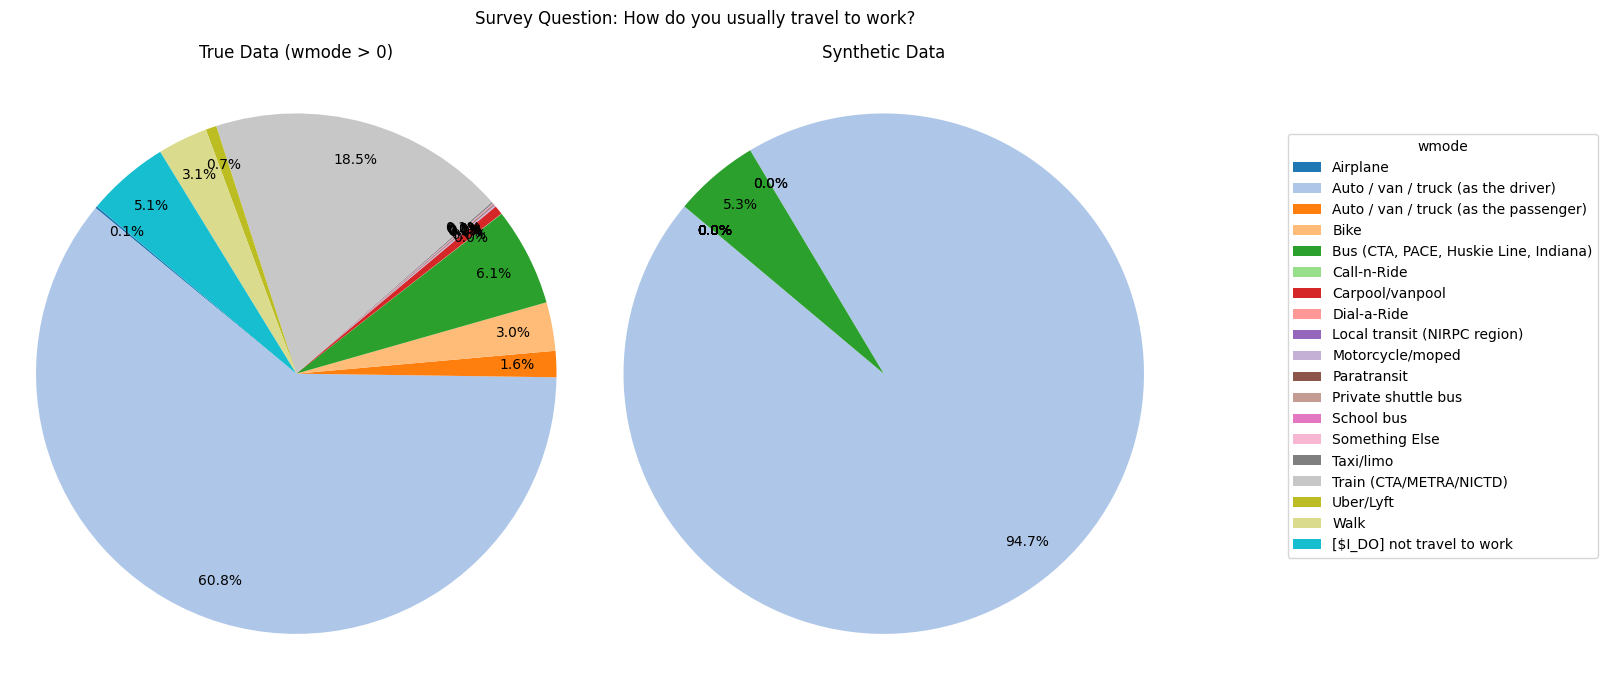

In [6]:
import seaborn as sns

def compare_pie_charts_with_mapping(df1, df2, col):
    mapping = response_map[col]

    # Filter df1 where col > 0
    df1_filtered = df1[df1[col] > 0]

    # Map values using provided dictionary
    df1_mapped = df1_filtered[col].map(mapping).value_counts()
    df2_mapped = df2[col].map(mapping).value_counts()

    # Align indices (ensure same label order)
    all_labels = sorted(set(df1_mapped.index).union(df2_mapped.index))
    df1_mapped = df1_mapped.reindex(all_labels, fill_value=0)
    df2_mapped = df2_mapped.reindex(all_labels, fill_value=0)

    # Generate color palette dynamically
    num_categories = len(all_labels)
    if num_categories <= 10:
        palette = sns.color_palette("tab10", num_categories)
    elif num_categories <= 20:
        palette = sns.color_palette("tab20", num_categories)
    else:
        cmap = plt.get_cmap('tab20c')  # Or 'hsv', 'nipy_spectral', etc.
        palette = [cmap(i / num_categories) for i in range(num_categories)]

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    wedges1, texts1, autotexts1 = axes[0].pie(
        df1_mapped,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        labeldistance=1.1,
        colors=palette
    )
    axes[0].set_title(f'True Data ({col} > 0)')
    axes[0].axis('equal')

    wedges2, texts2, autotexts2 = axes[1].pie(
        df2_mapped,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        labeldistance=1.1,
        colors=palette
    )
    axes[1].set_title(f'Synthetic Data')
    axes[1].axis('equal')

    # Create one legend for both charts
    fig.legend(wedges1, all_labels, title=col, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize='medium')

    question = query_dict[col.upper()]["question"]
    fig.suptitle(f"Survey Question: {question}")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit legend
    plt.show()

# Example usage:
compare_pie_charts_with_mapping(true_df, clean, "wmode")

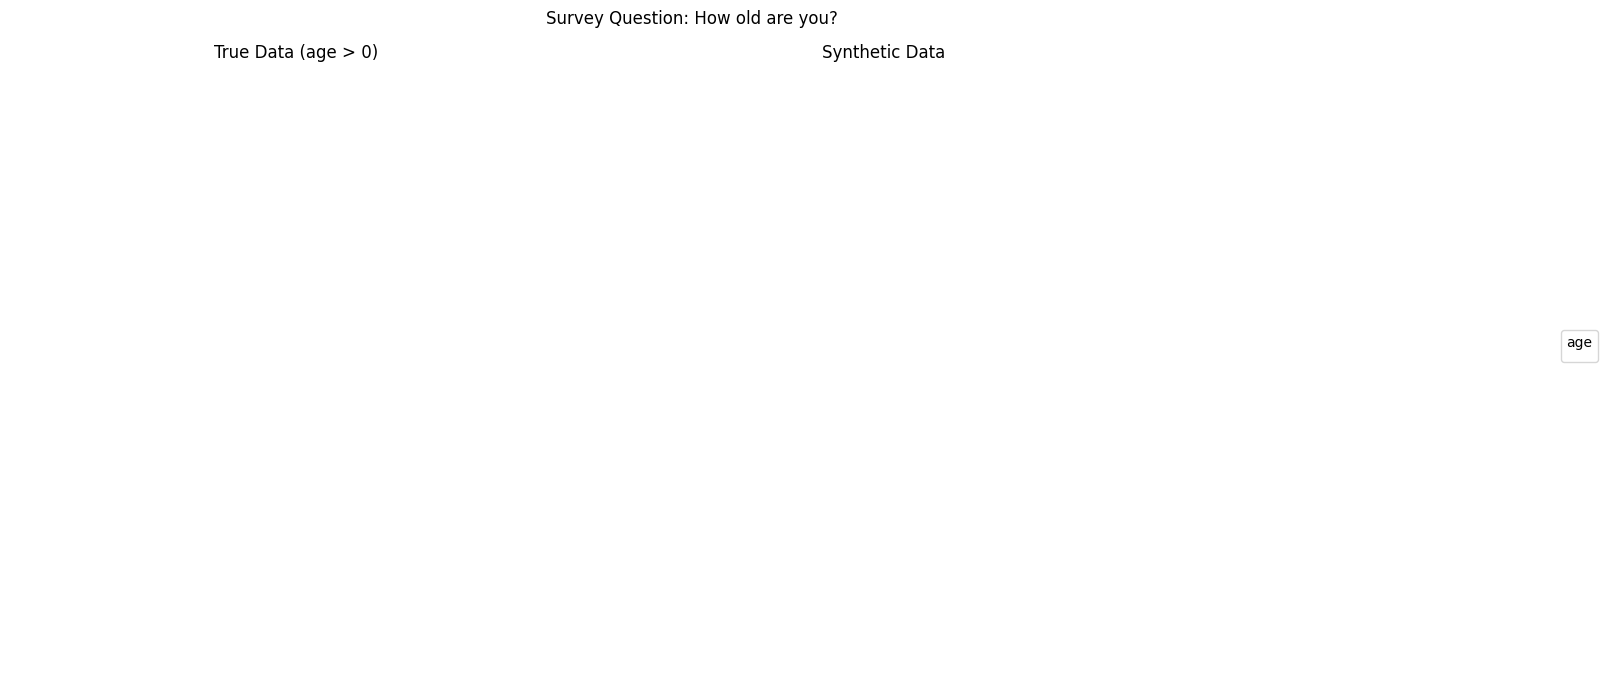

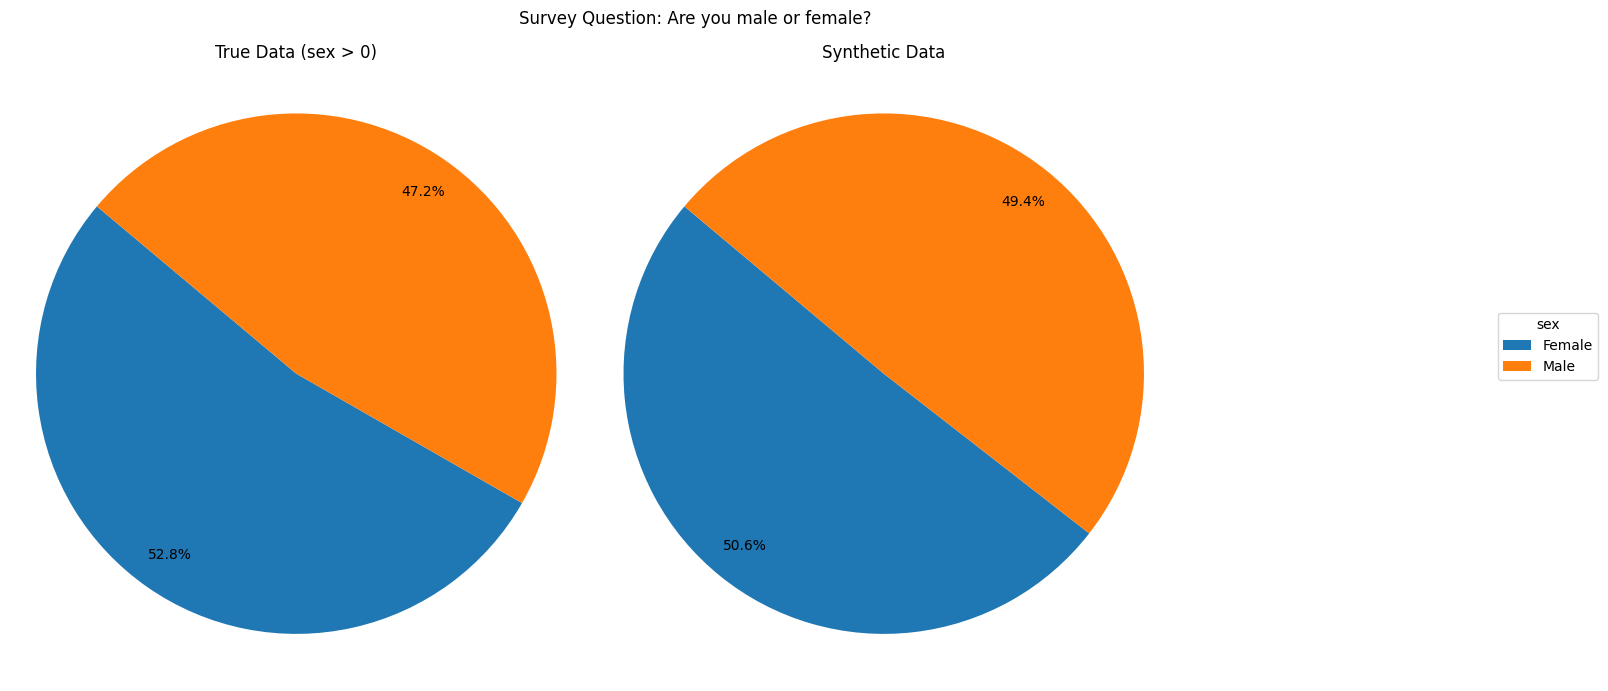

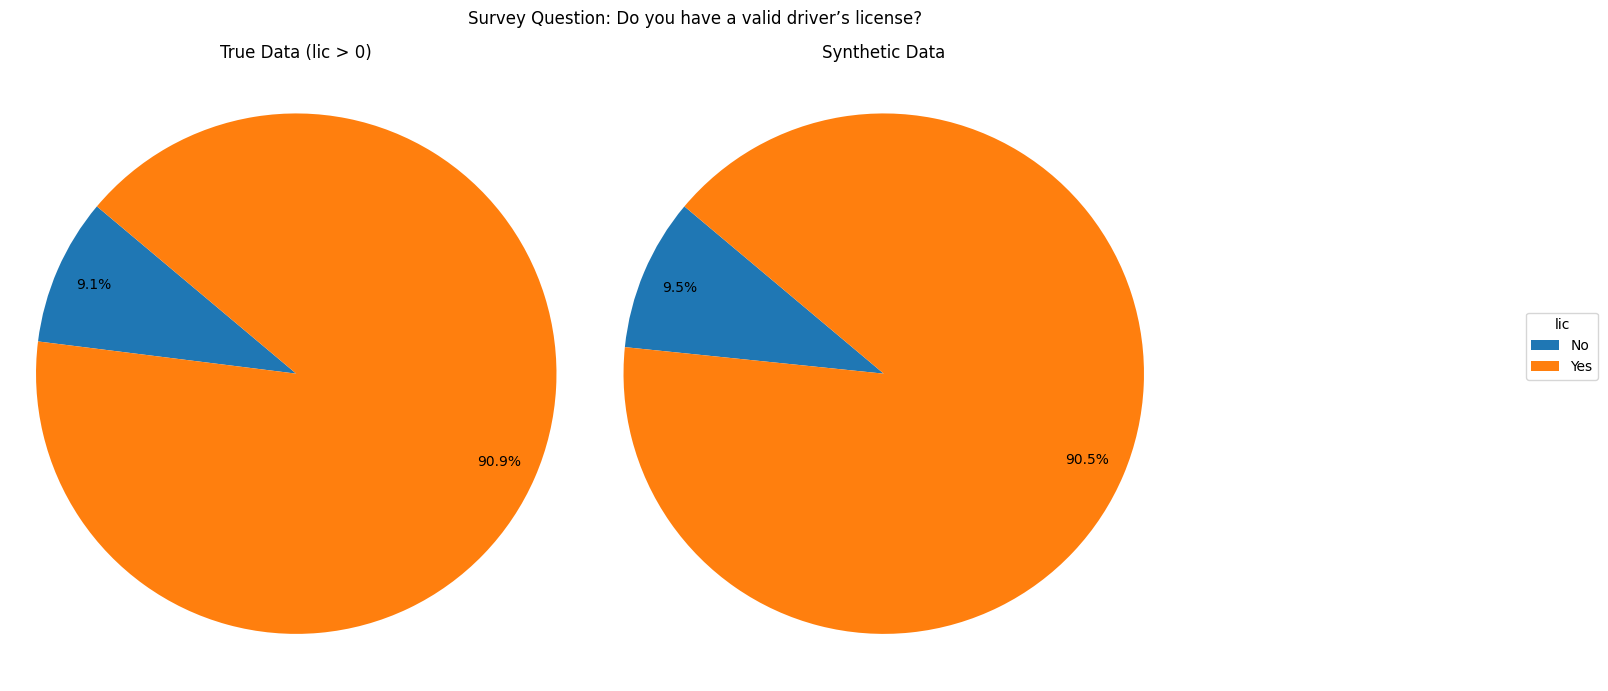

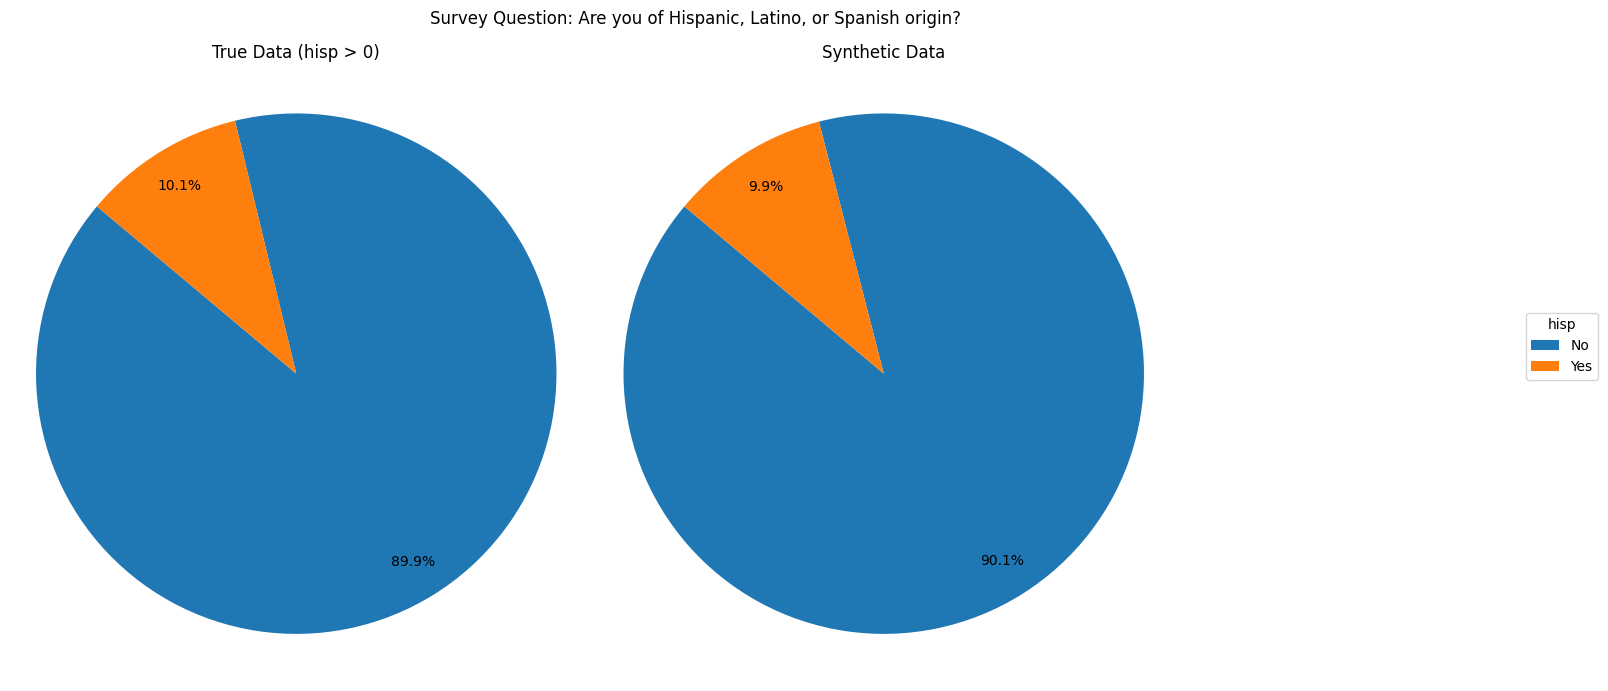

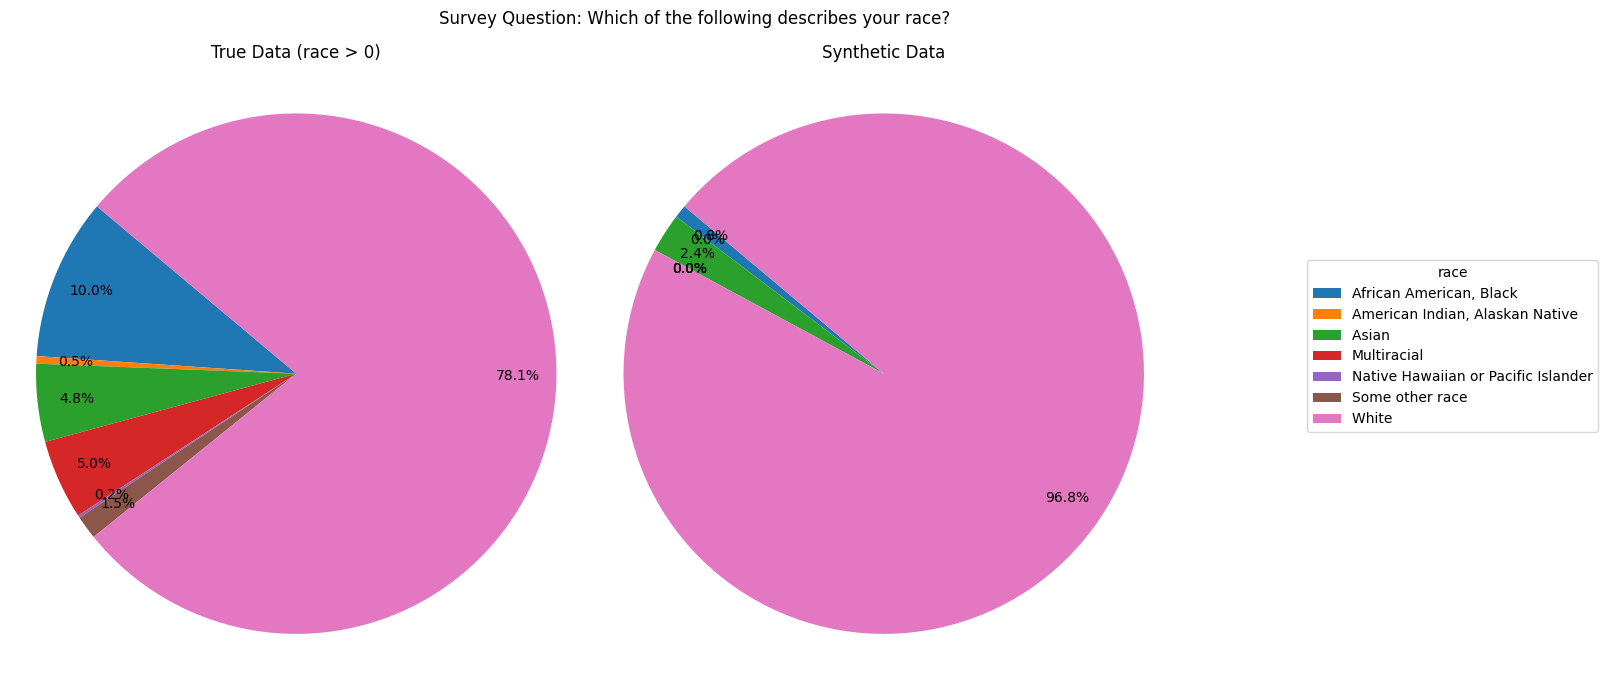

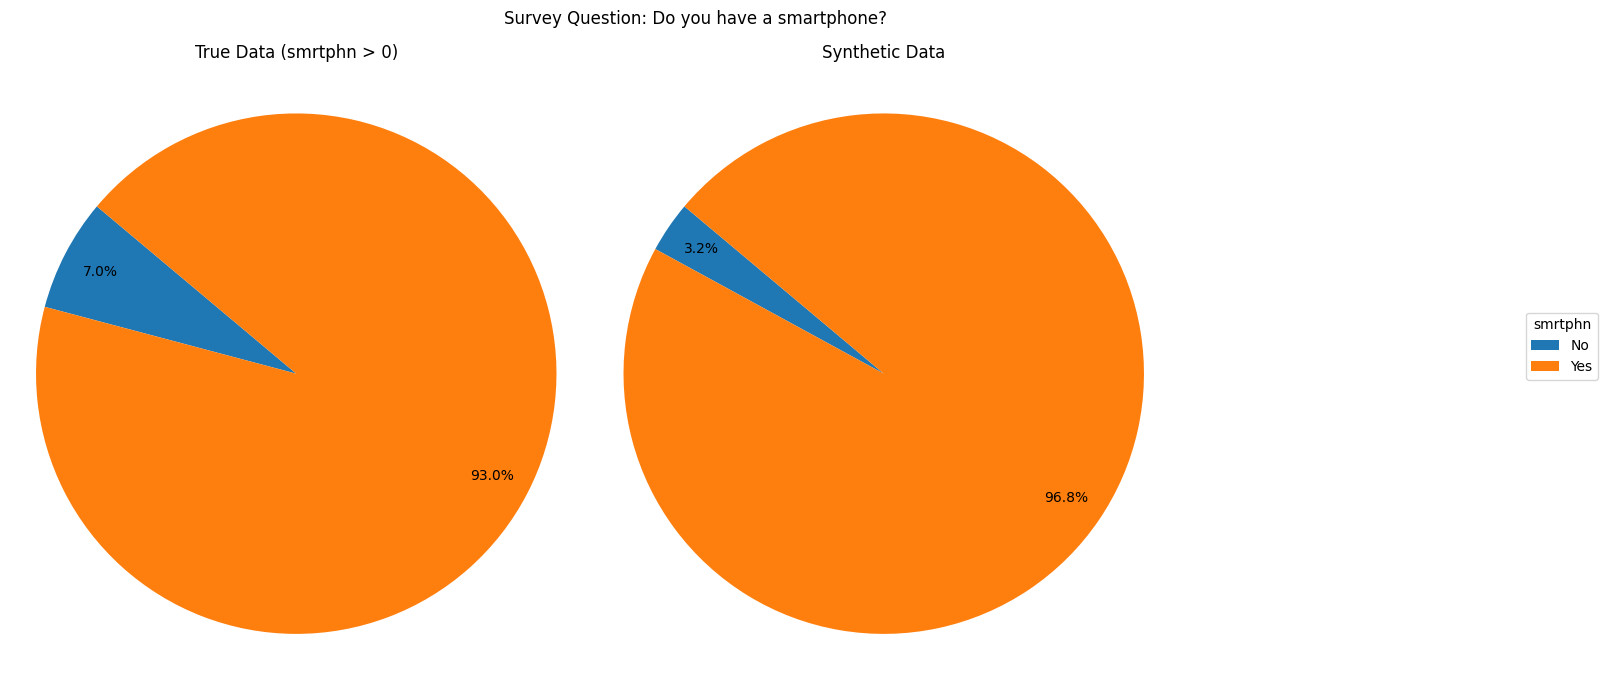

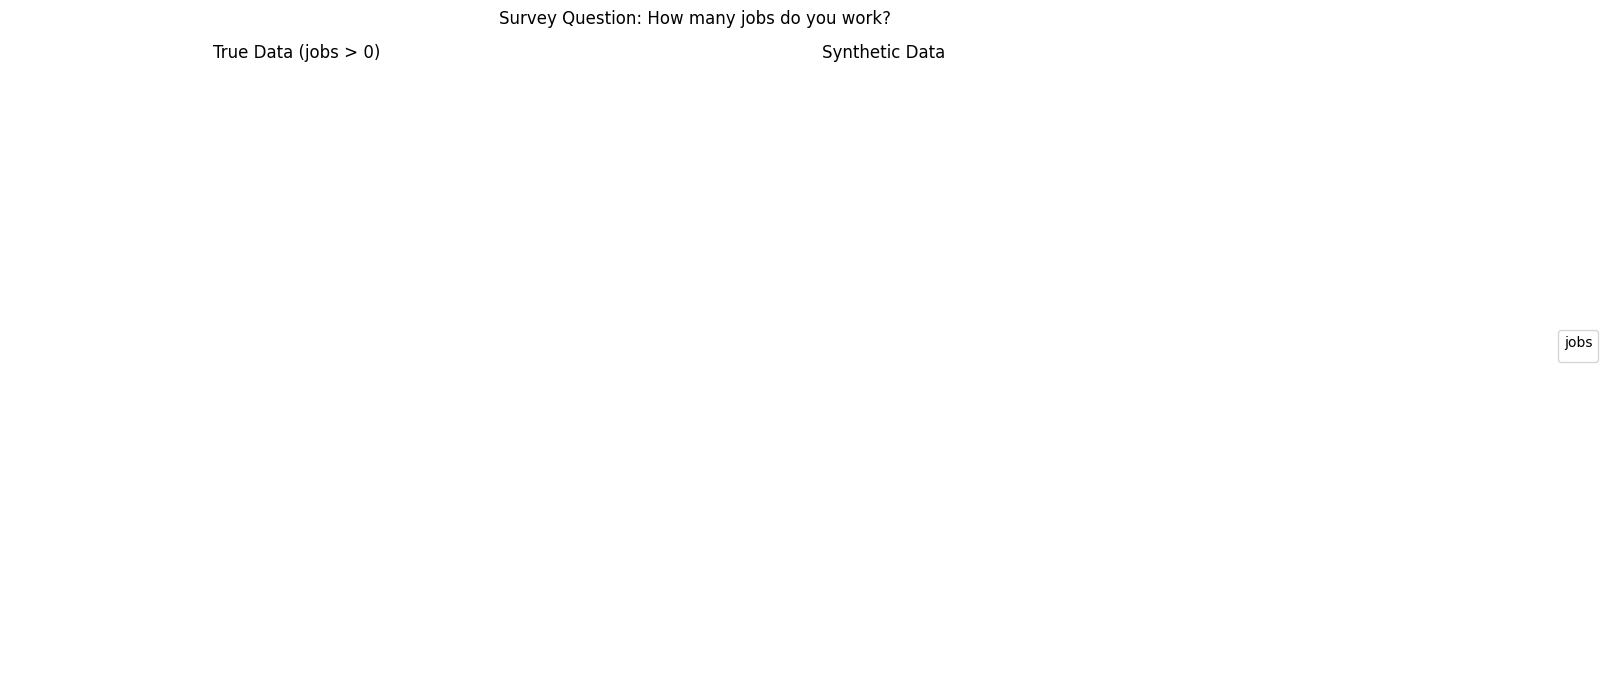

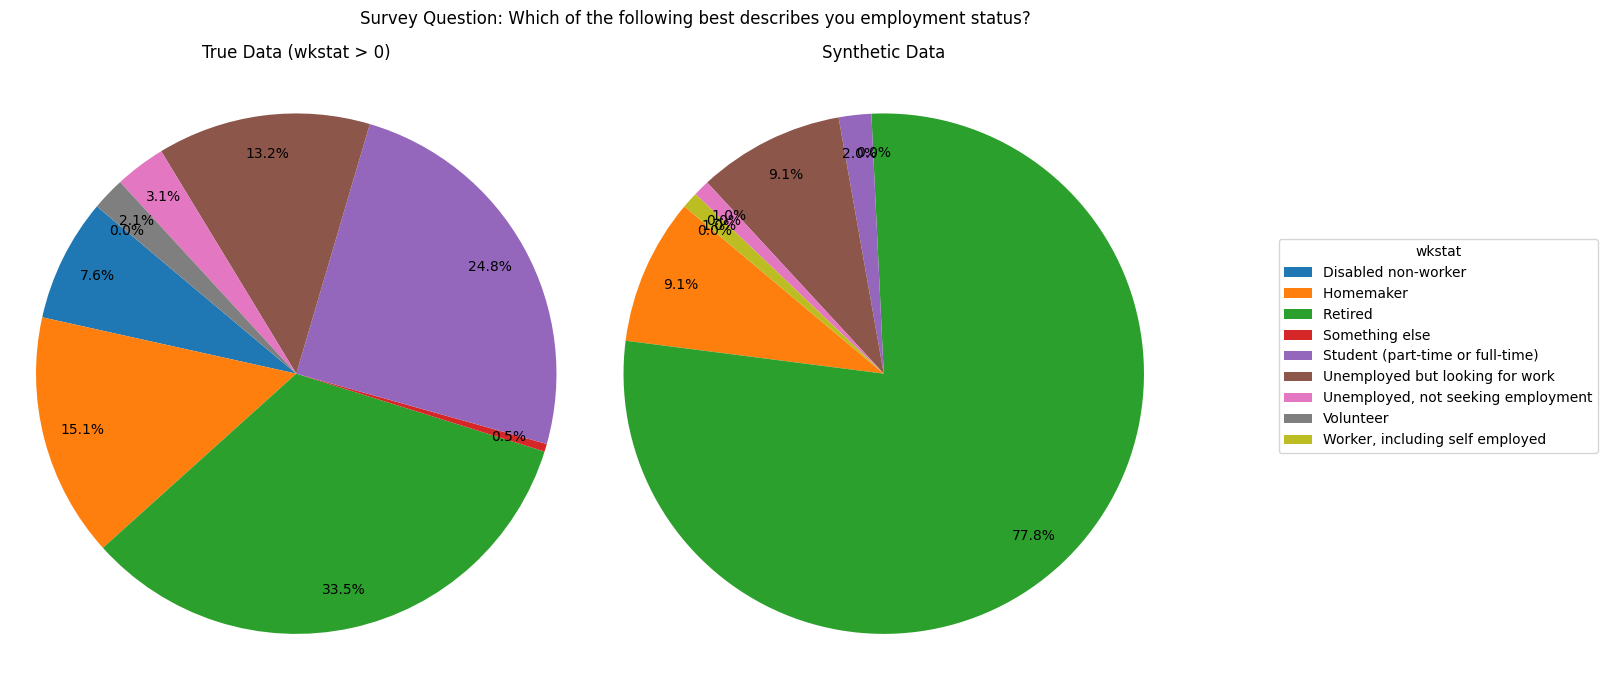

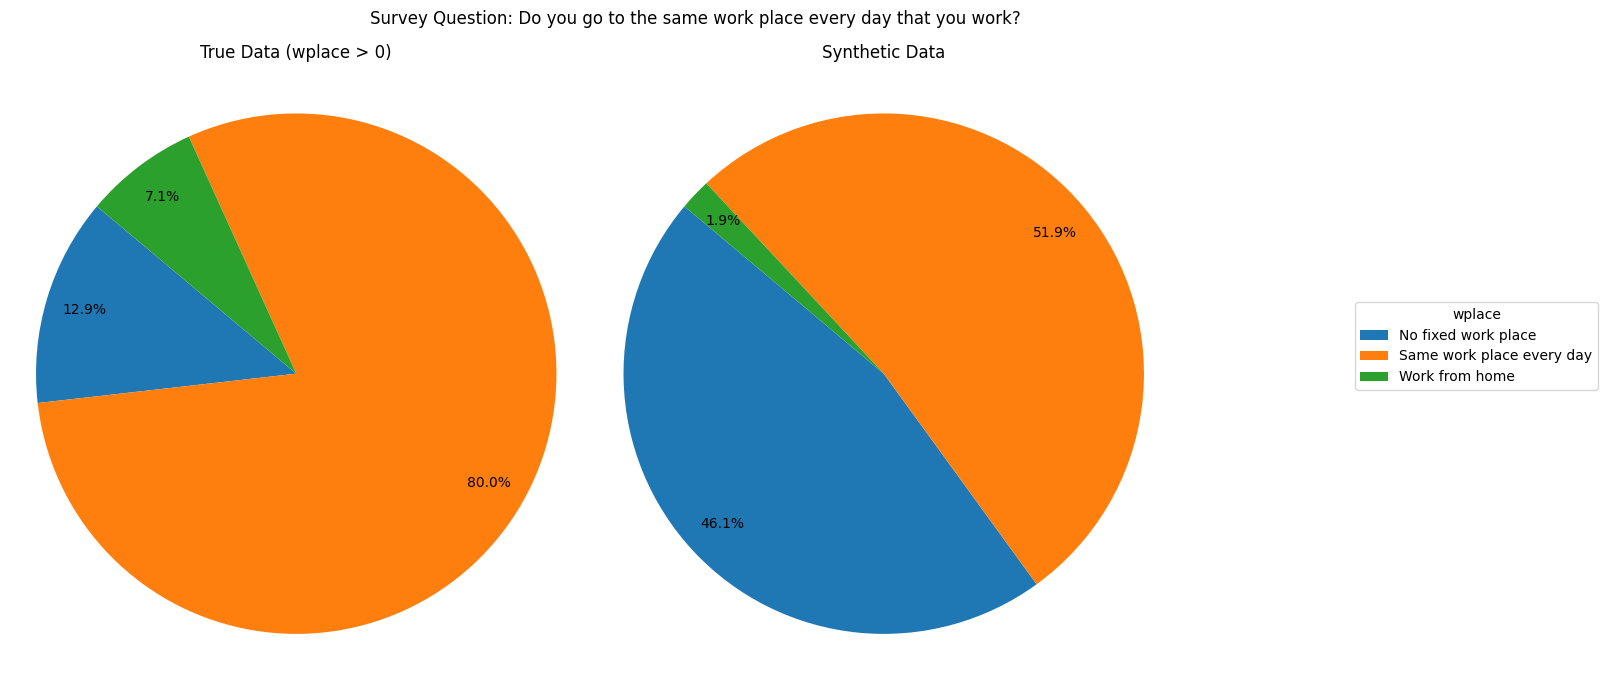

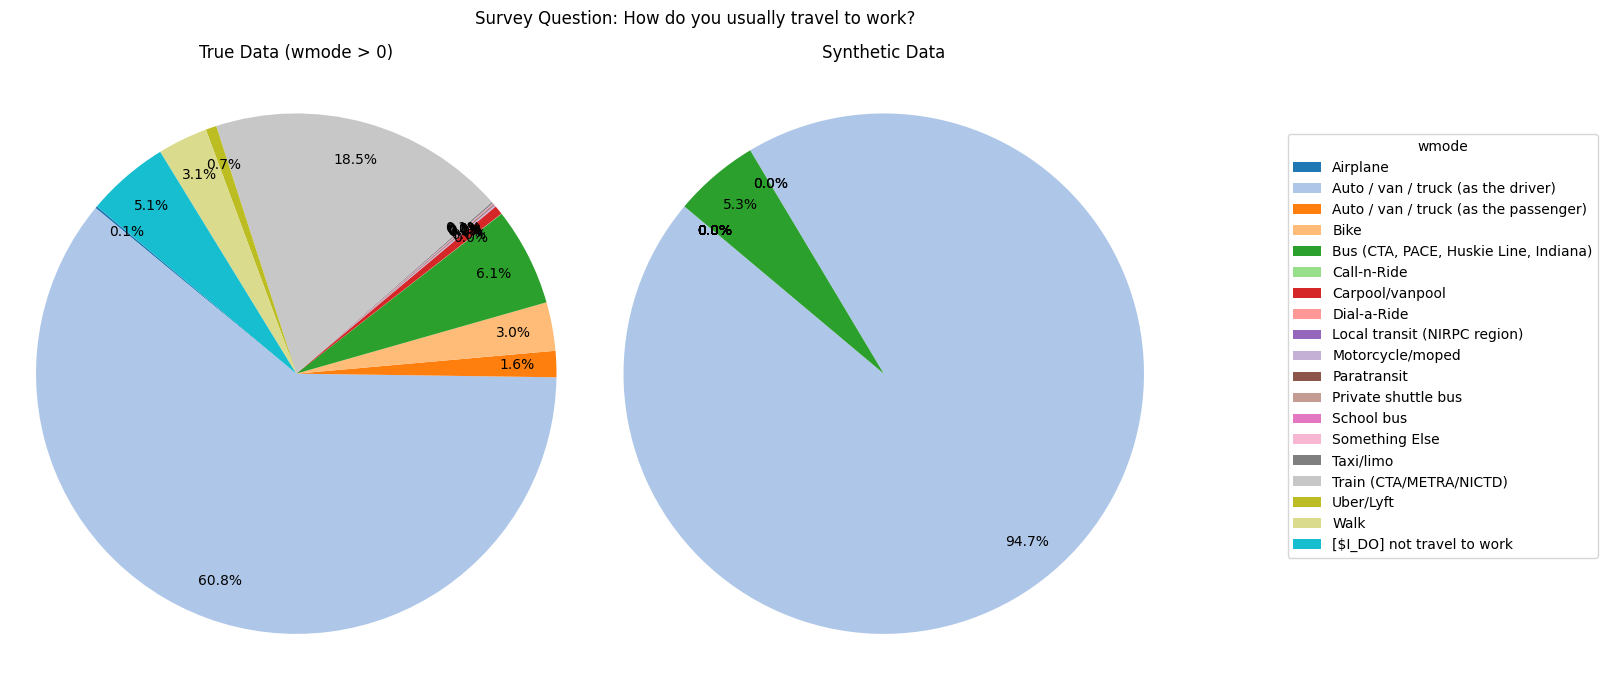

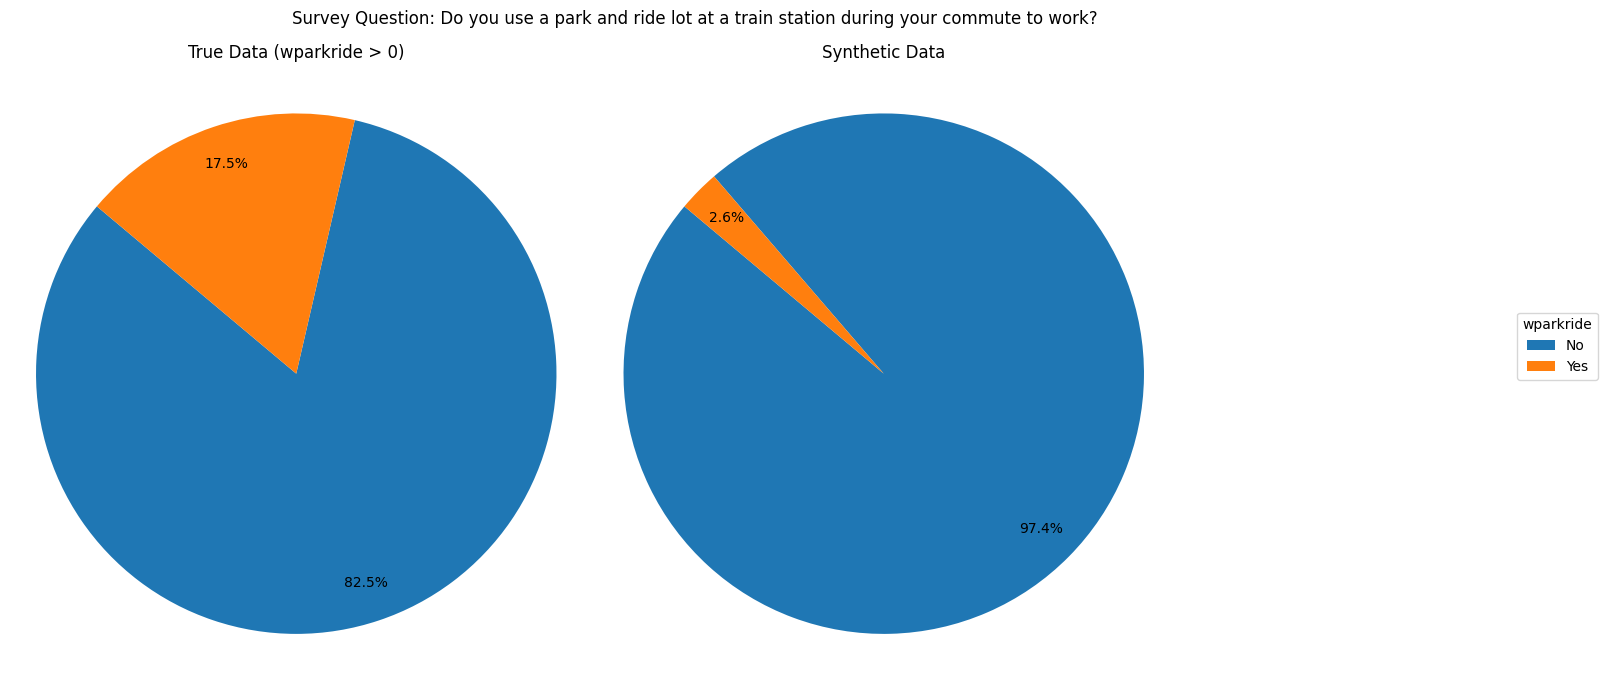

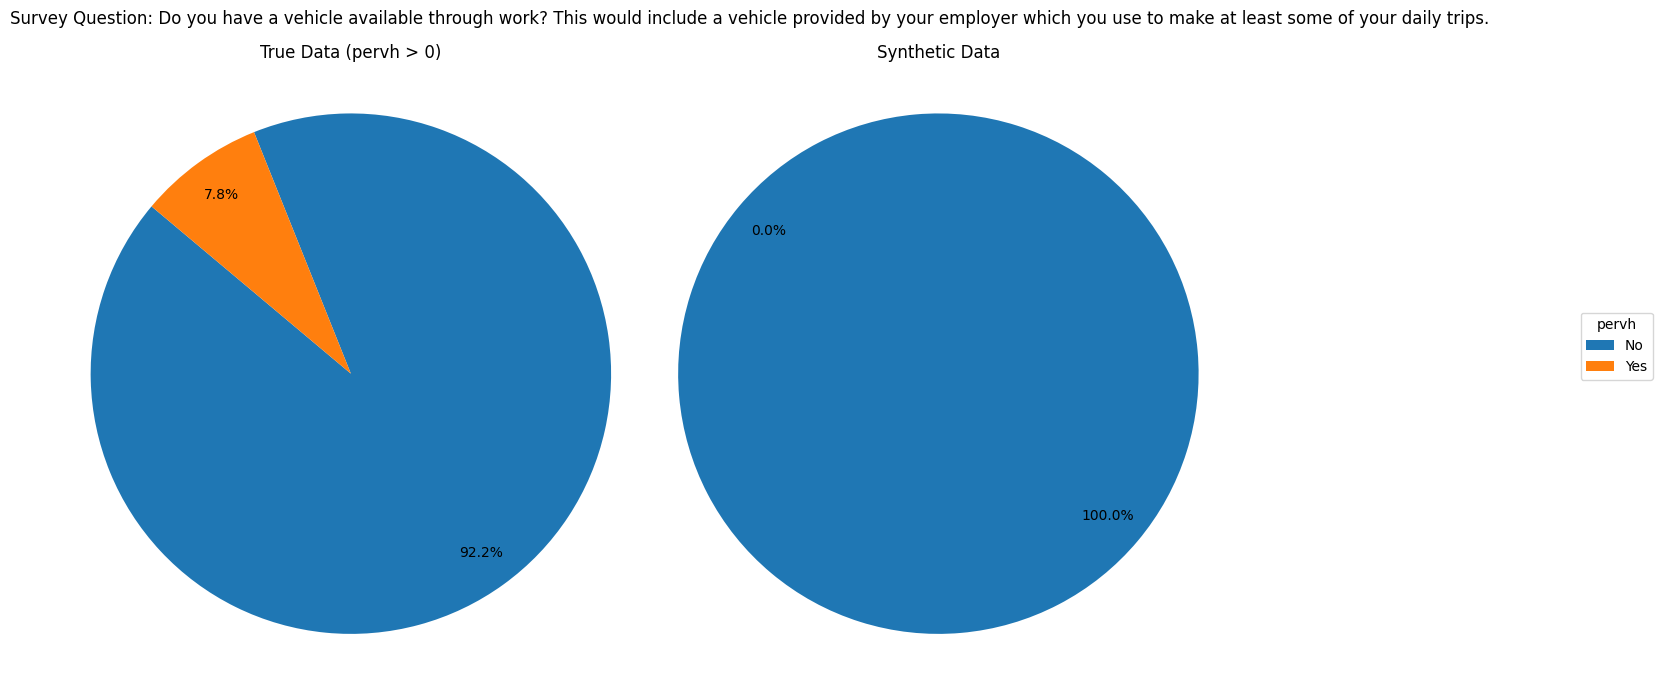

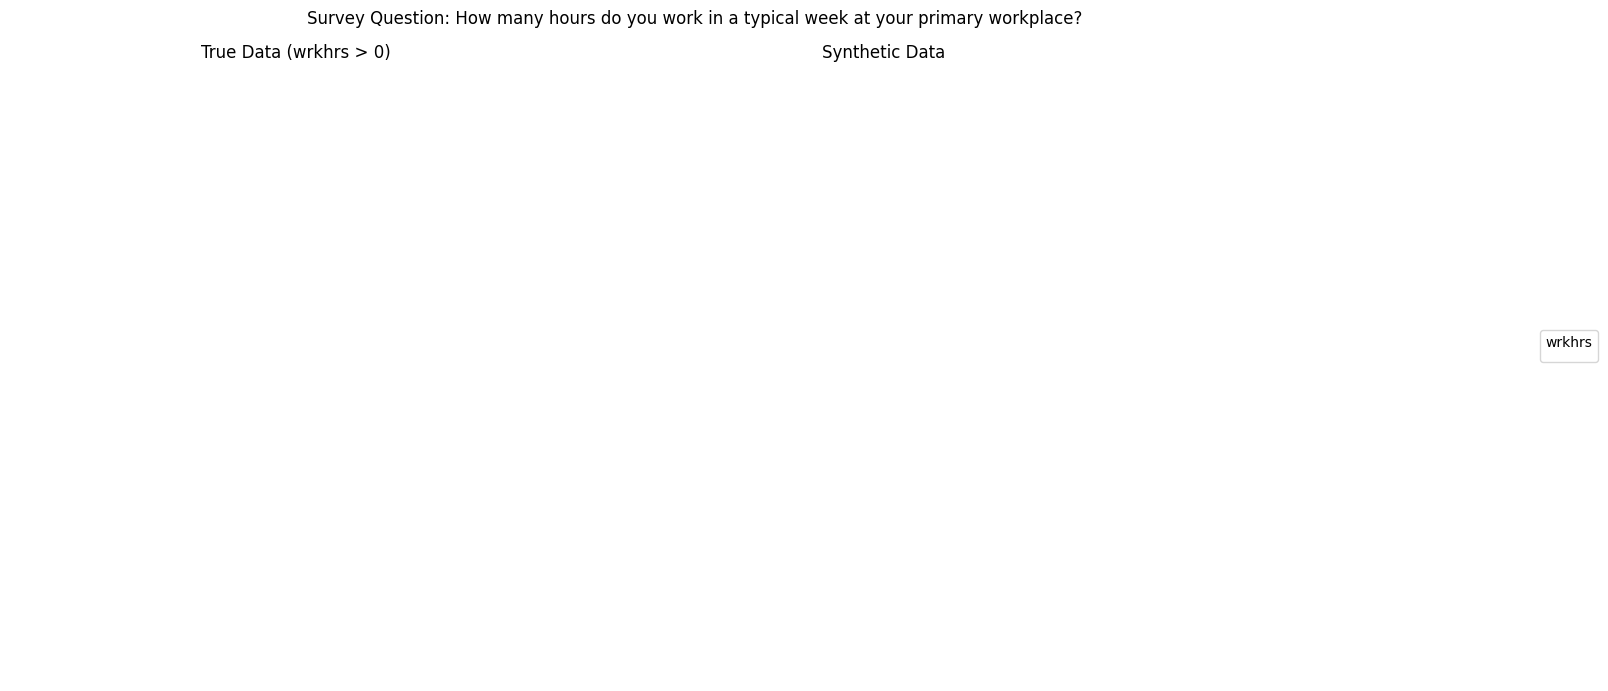

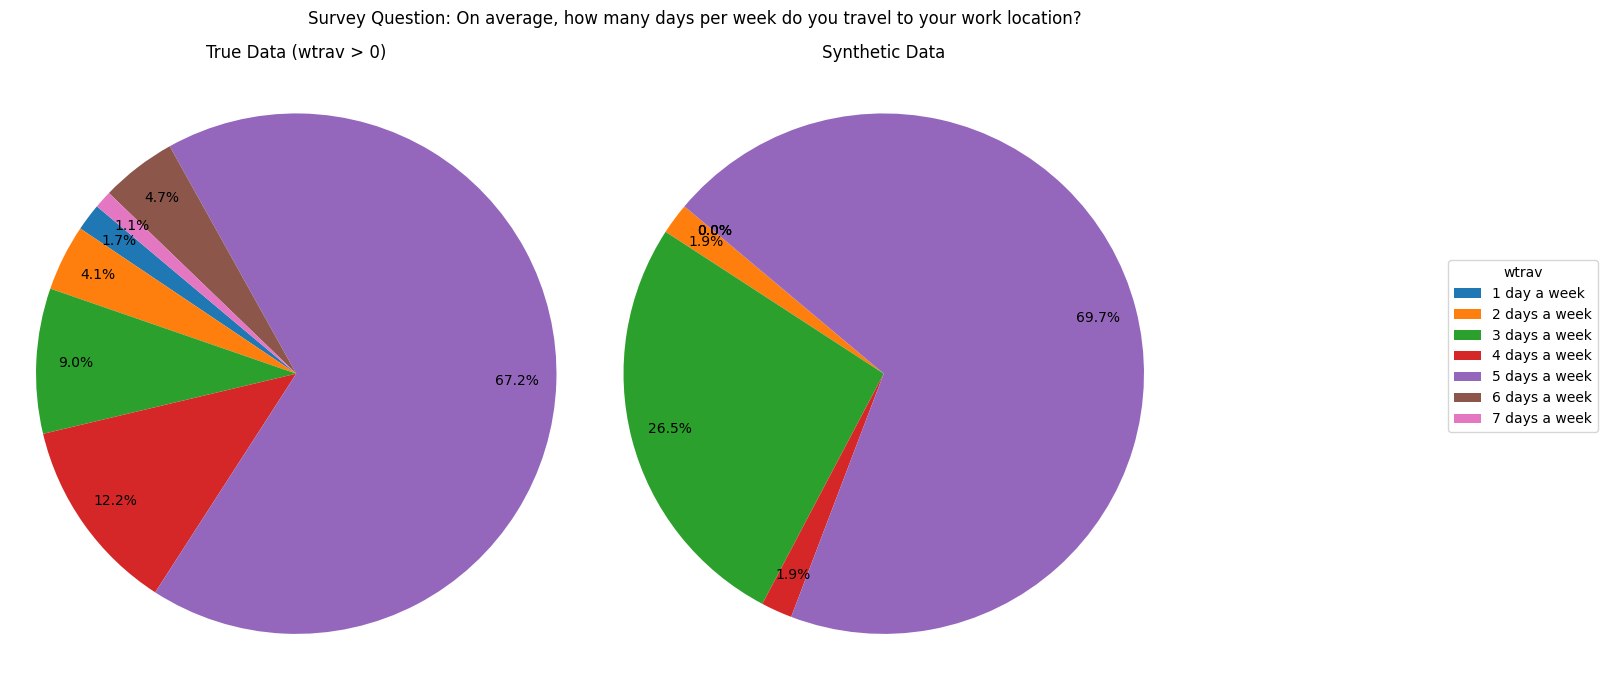

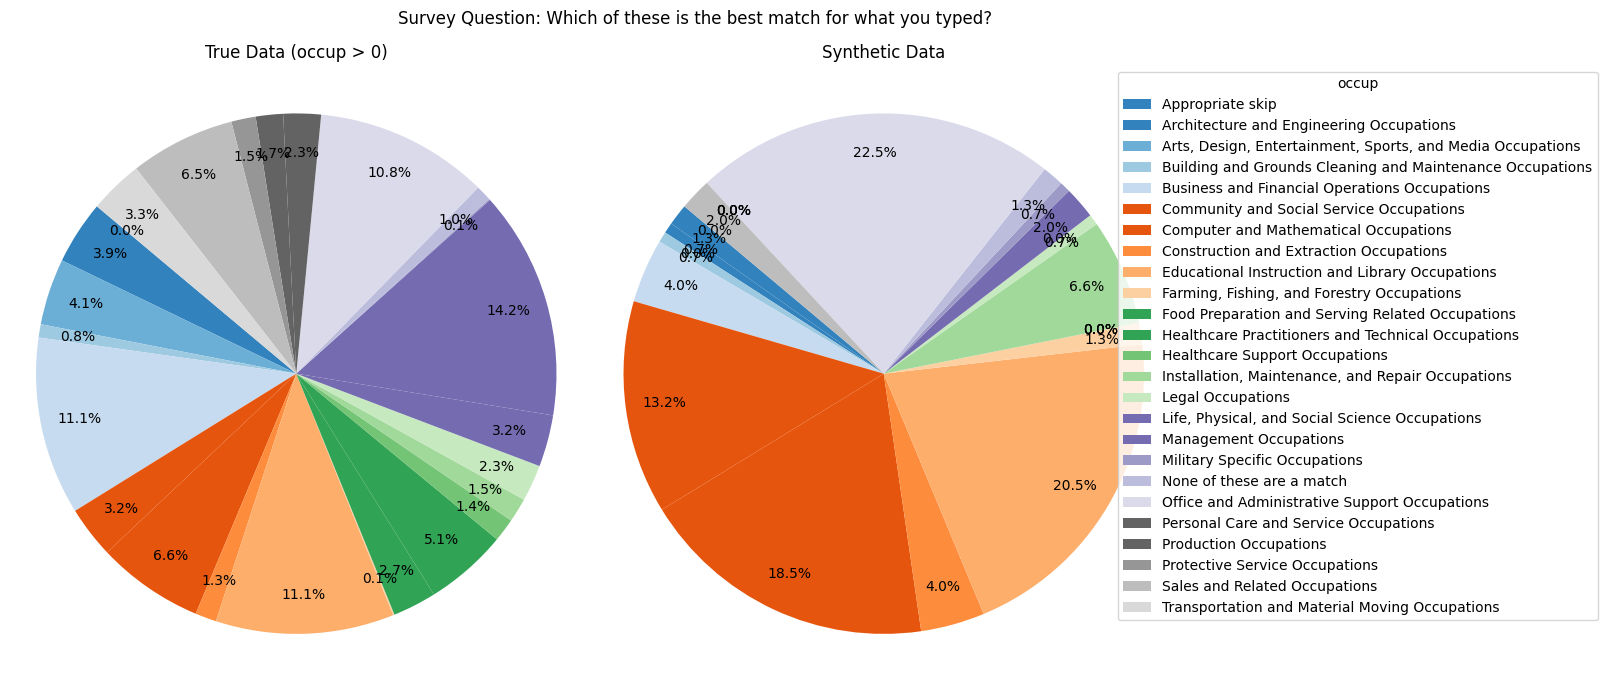

indus failed


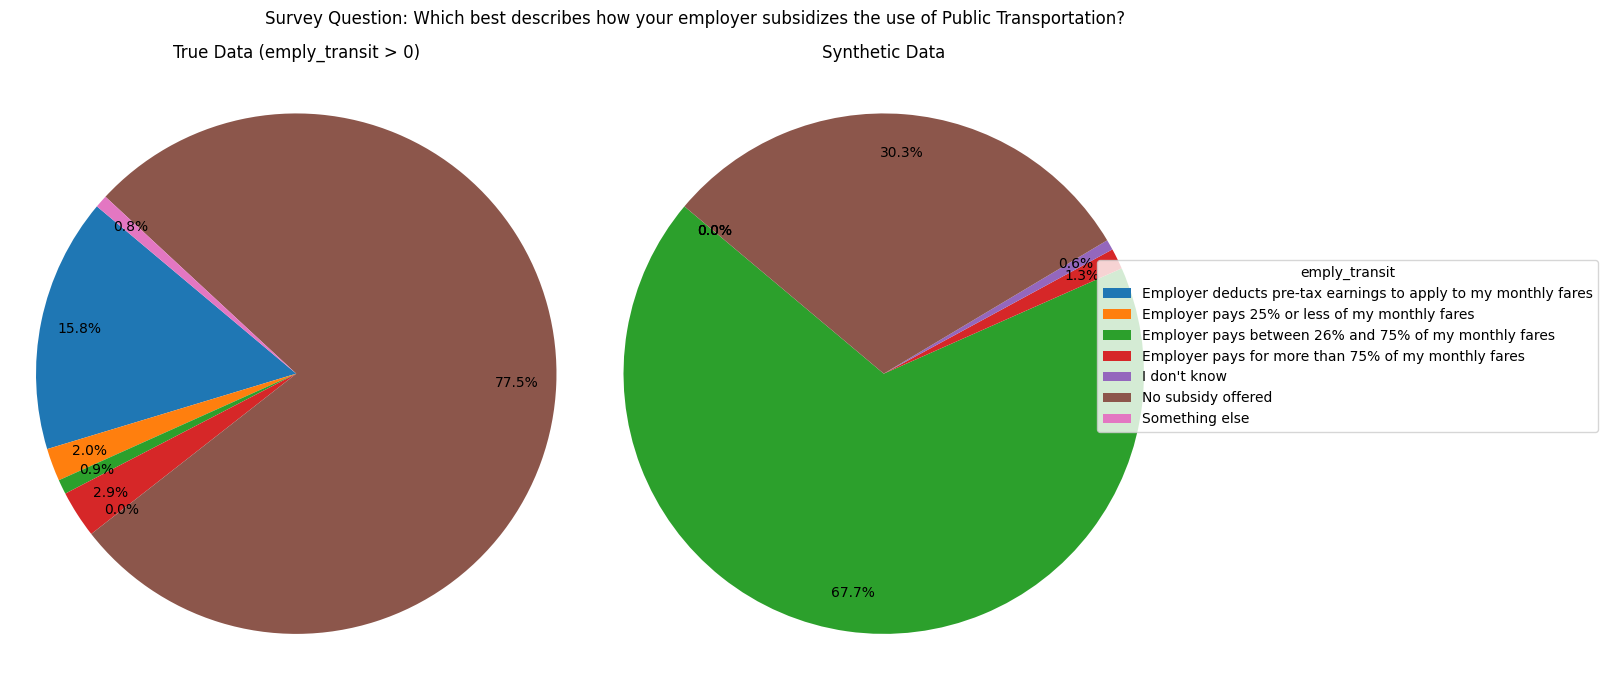

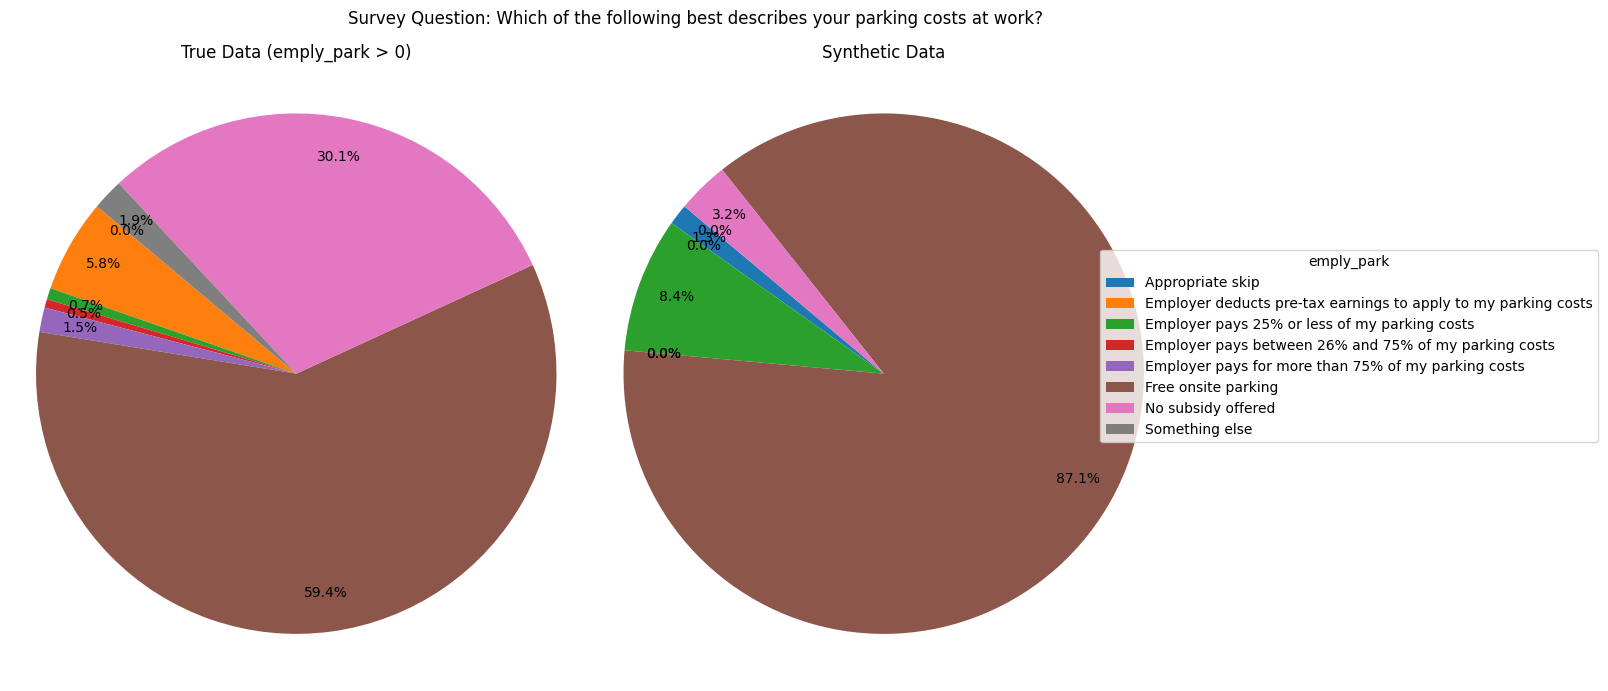

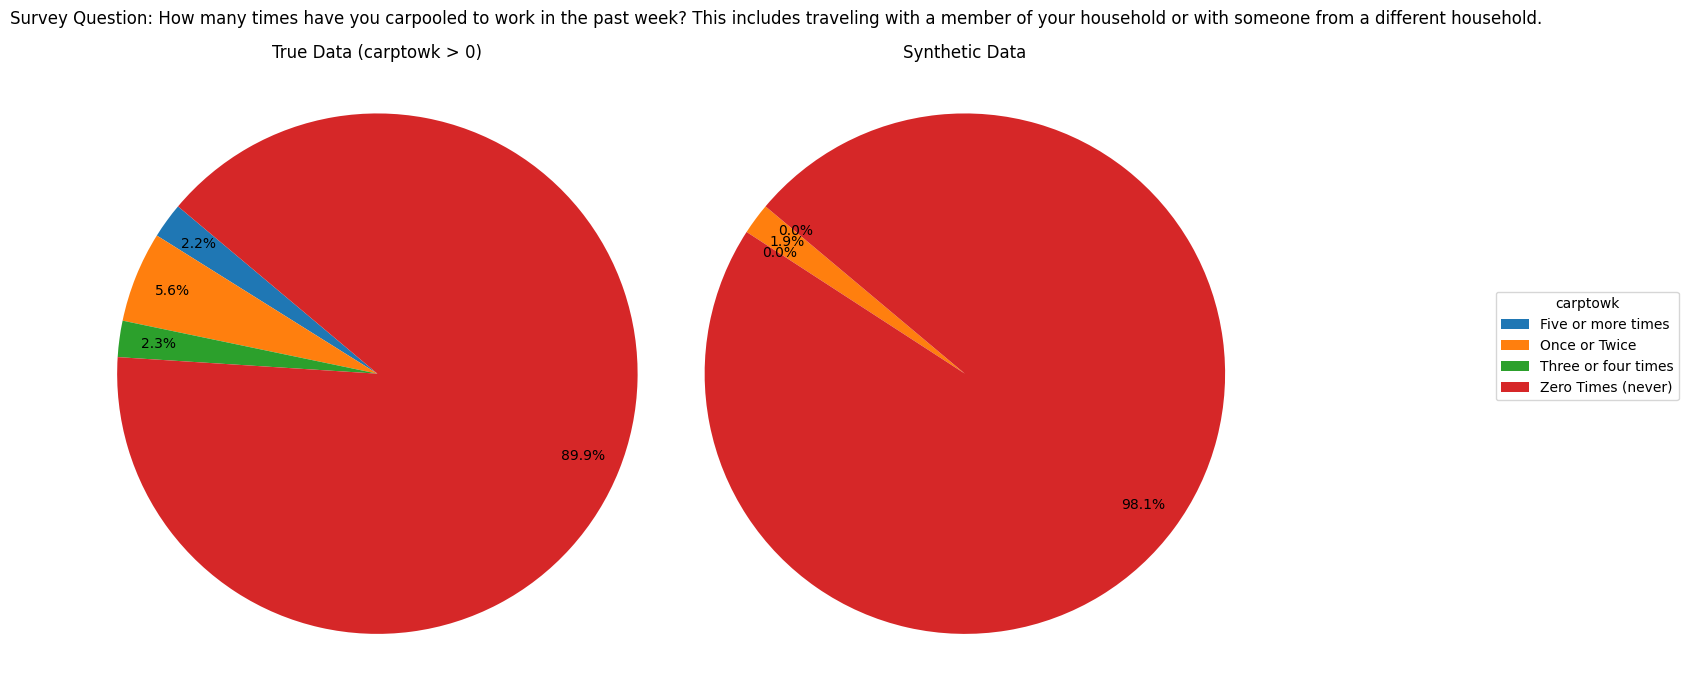

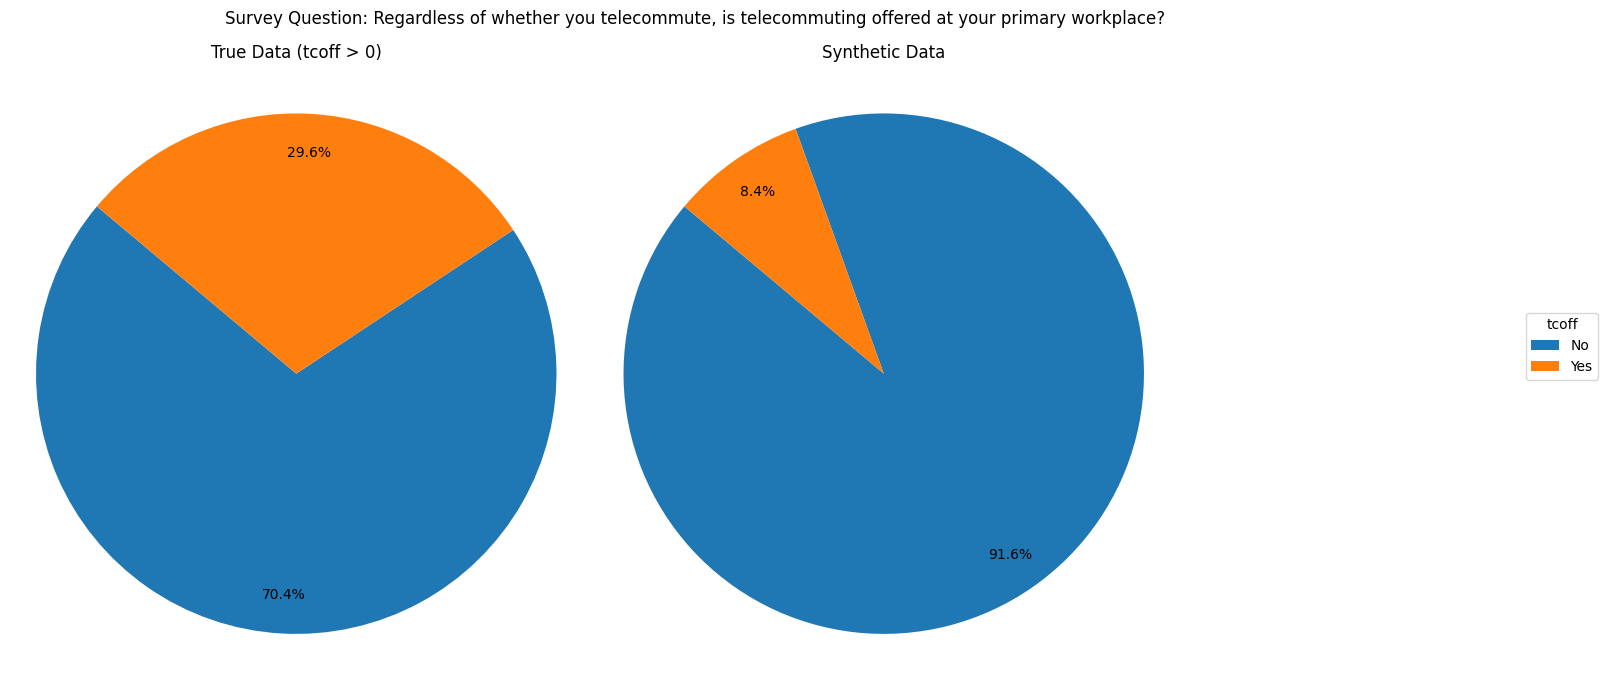

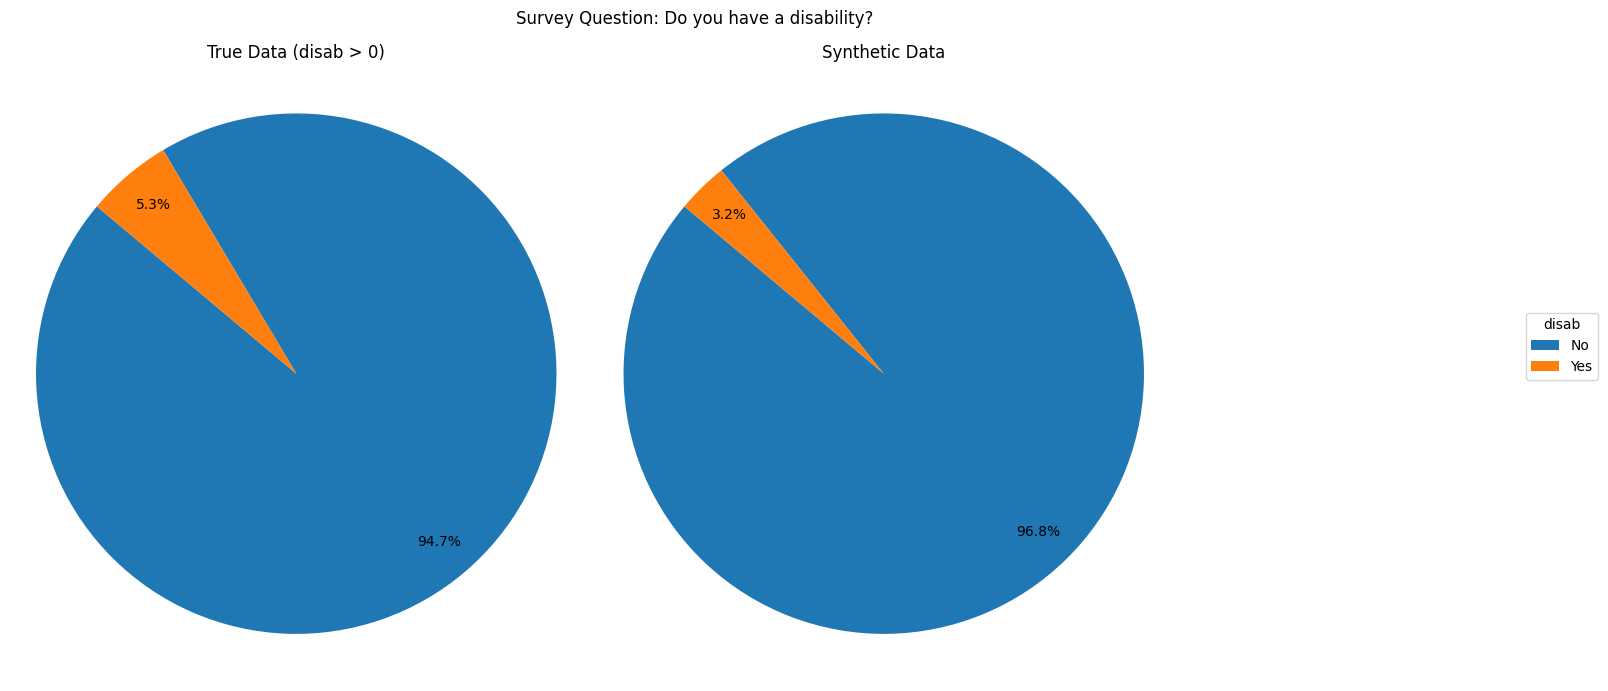

dtype_o failed


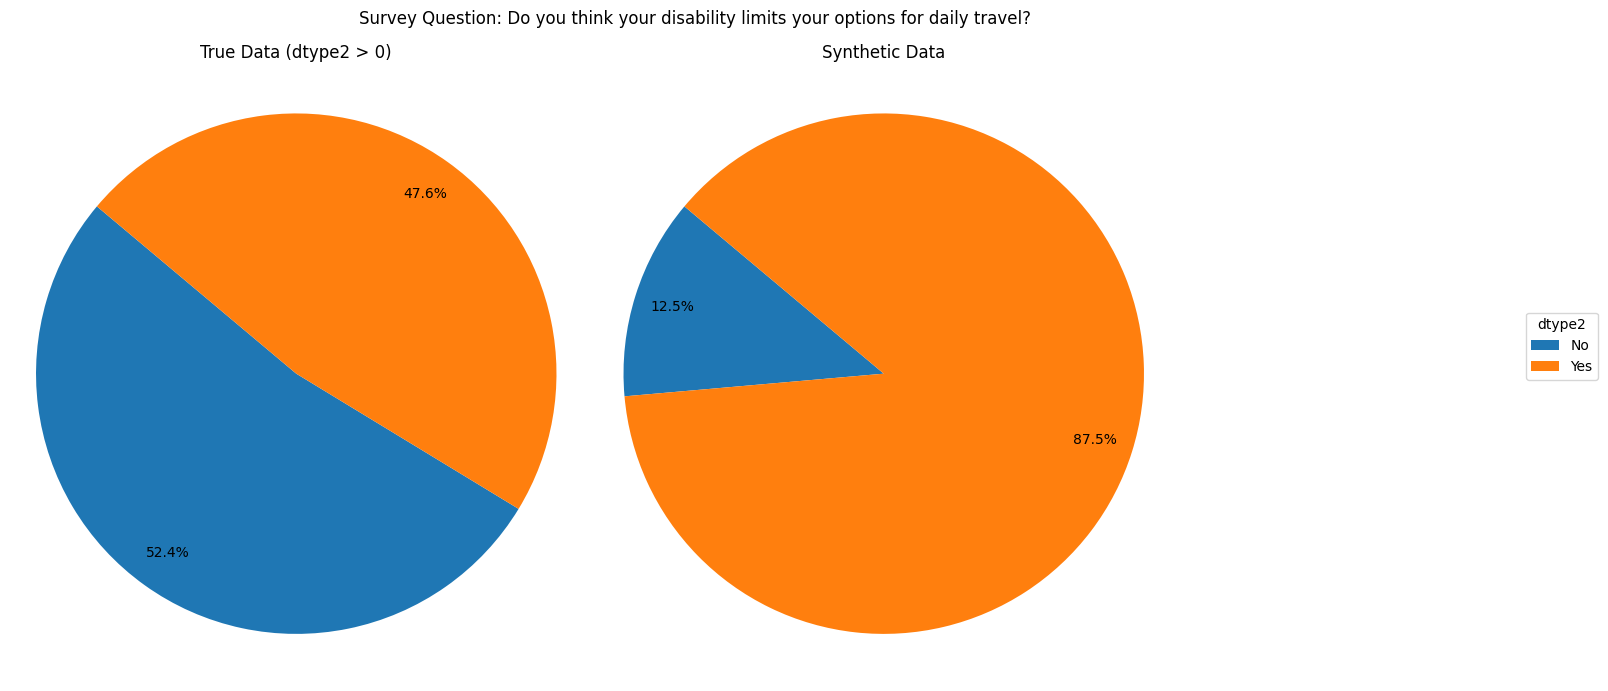

traveldatadevice failed


In [5]:
for col in int_cols:
    try:
        compare_pie_charts_with_mapping(true_df, clean, col)
    except:
        print(f"{col} failed")

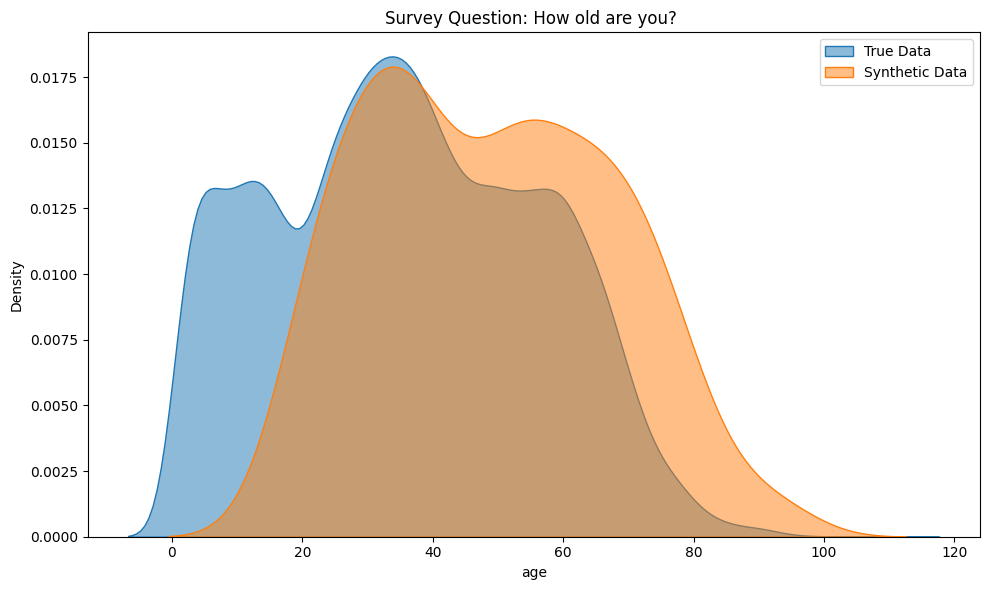

In [ ]:
def compare_kde_plots(df1, df2, col, show_hist=False):
    # Filter out non-positive values
    df1_filtered = df1[df1[col] > 0]
    df2_filtered = df2[df2[col] > 0]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot KDE and optional histogram
    sns.kdeplot(df1_filtered[col].dropna(), label='True Data', fill=True, alpha=0.4)
    sns.kdeplot(df2_filtered[col].dropna(), label='Synthetic Data', fill=True, alpha=0.4)

    if show_hist:
        sns.histplot(df1_filtered[col].dropna(), bins=30, kde=False, stat="density", color='blue', alpha=0.3, label='True Data (hist)')
        sns.histplot(df2_filtered[col].dropna(), bins=30, kde=False, stat="density", color='orange', alpha=0.3, label='Synthetic Data (hist)')

    # Title and labels
    plt.title(f"Survey Question: {query_dict.get(col.upper(), {}).get('question', col)}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_kde_plots(true_df, clean, "age")

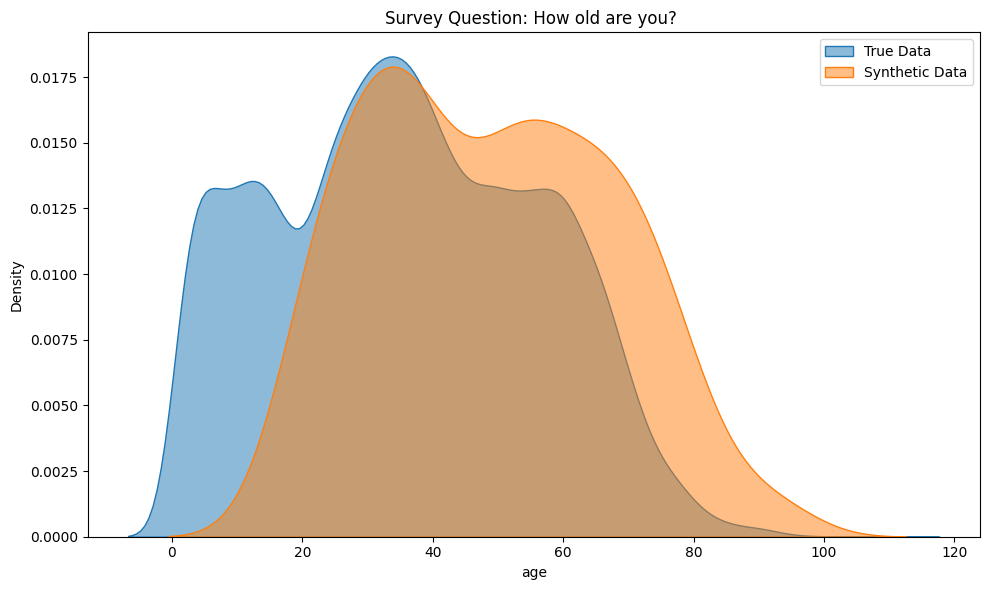

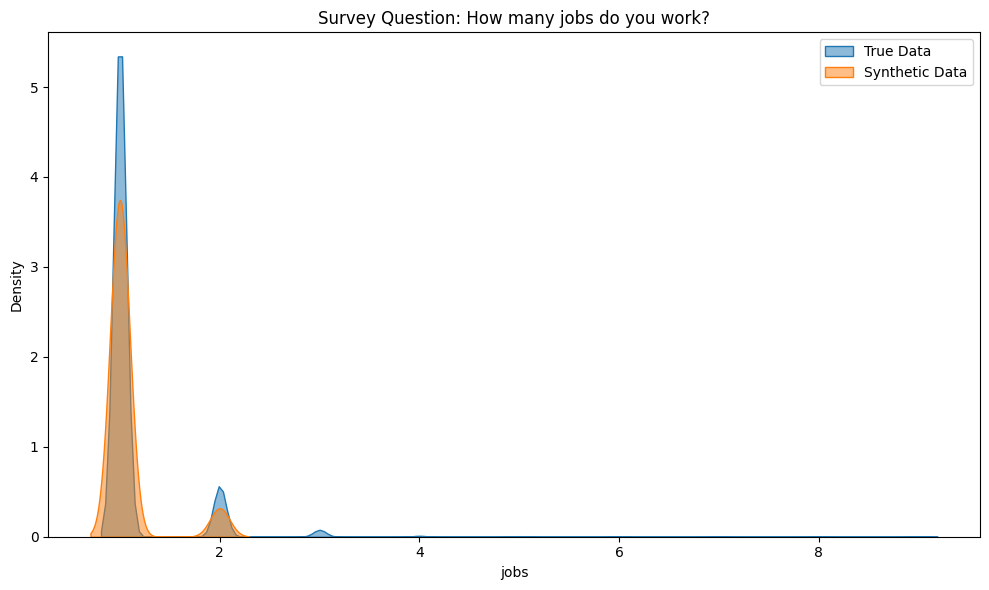

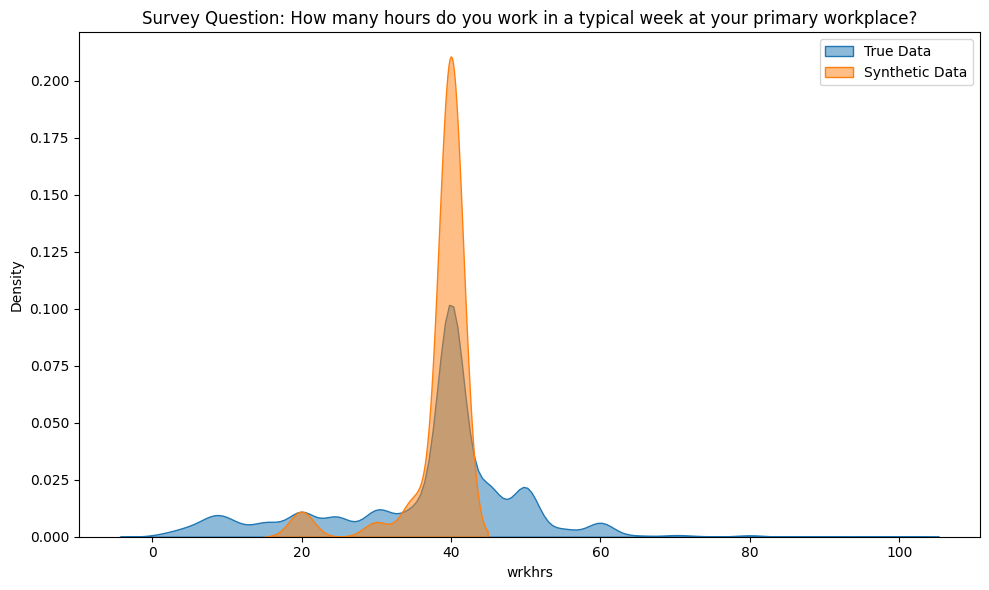

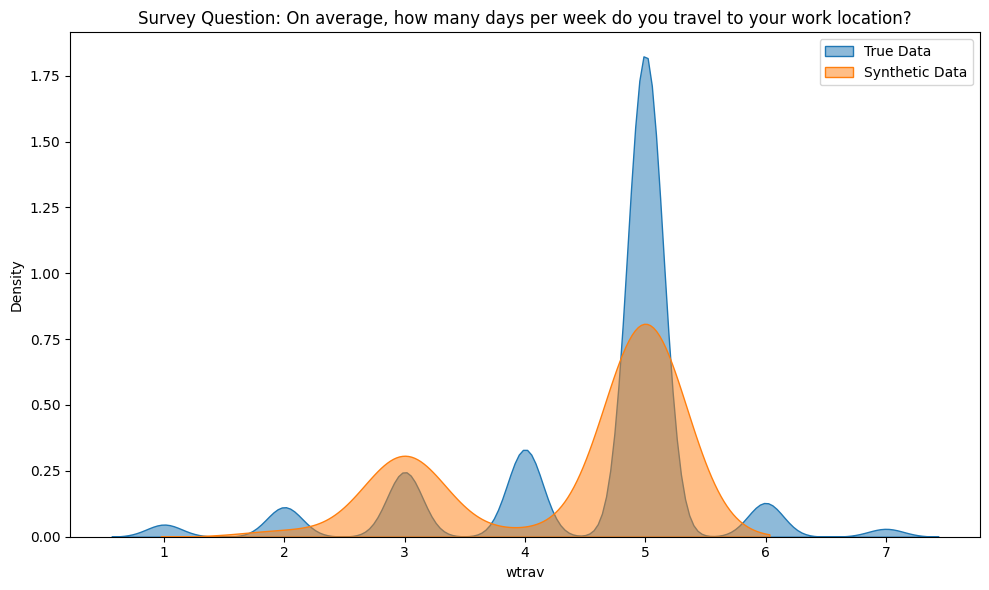

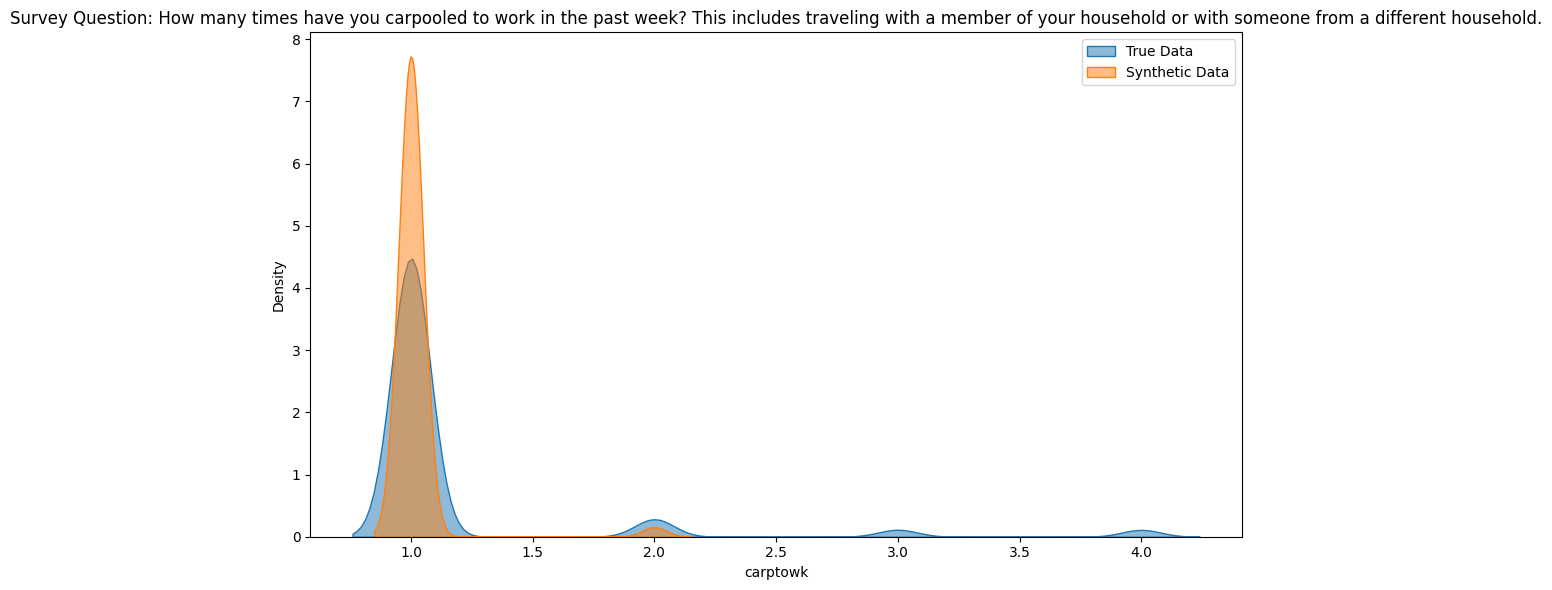

In [ ]:
continuous_vars = [
    "age",
    "jobs",
    "wrkhrs",
    "wtrav",
    "carptowk"
]

hist_flag = [False, True, False, True, True]

for flag, var in zip(hist_flag, continuous_vars):
    compare_kde_plots(true_df, clean, var, show)